# Part 1

## Question 1 - OIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
from math import log, sqrt, exp
from scipy import integrate
pd.set_option('display.precision', 6)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import brentq, least_squares, curve_fit
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

In [2]:
# Get OIS data
data = pd.ExcelFile('IR Data.xlsx')
ois_data = pd.read_excel(data, sheet_name=1) 

ois_data

,Tenor,Product,Rate,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,6m,OIS,0.00250,NaN,Day Count Convention,30/360
1,1y,OIS,0.00300,NaN,O/N Leg Frequency,Daily
2,2y,OIS,0.00325,NaN,Fixed Leg Frequency,Annual
3,3y,OIS,0.00335,NaN,NaN,NaN
4,4y,OIS,0.00350,NaN,NaN,NaN
5,5y,OIS,0.00360,NaN,NaN,NaN
6,7y,OIS,0.00400,NaN,NaN,NaN
7,10y,OIS,0.00450,NaN,NaN,NaN
8,15y,OIS,0.00500,NaN,NaN,NaN
9,20y,OIS,0.00525,NaN,NaN,NaN


In [3]:
# Clean up
ois_data = ois_data.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)
ois_data

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350
5,5y,OIS,0.00360
6,7y,OIS,0.00400
7,10y,OIS,0.00450
8,15y,OIS,0.00500
9,20y,OIS,0.00525


In [4]:
ois_data['Tenor']

0      6m
1      1y
2      2y
3      3y
4      4y
5      5y
6      7y
7     10y
8     15y
9     20y
10    30y
Name: Tenor, dtype: object

In [5]:
# Parse Tenors
def tenor_to_years(tenor):
    tenor_str = str(tenor)
    if 'm' in tenor_str:
        return int(tenor.strip('m')) / 12
    elif 'y' in tenor_str:
        return int(tenor.strip('y'))
    else:
        raise ValueError("Unrecognized tenor format")
        
ois_data['Tenor'] = ois_data['Tenor'].apply(tenor_to_years)

ois_data['Tenor']

0      0.5
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      7.0
7     10.0
8     15.0
9     20.0
10    30.0
Name: Tenor, dtype: float64

In [6]:
# Introduce new columns
ois_data['Forward Rate'] = np.nan
ois_data['Discount Factor'] = np.nan

# Constants
days_per_year = 360

# Calculate the first forward rate using the 6-month OIS rate
ois_data.at[0, 'Forward Rate'] = (((1 + (0.5 * ois_data.at[0, 'Rate'])) ** (1 / (ois_data.at[0, 'Tenor'] * days_per_year))) - 1) * days_per_year

# Calculate the first discount factor using the computed forward rate
ois_data.at[0, 'Discount Factor'] = (1 / (1 + (ois_data.at[0, 'Forward Rate'] / days_per_year))) ** (ois_data.at[0, 'Tenor'] * days_per_year)

# Calculate the second forward rate using the 1-year OIS rate and the first forward rate
ois_data.at[1, 'Forward Rate'] = (((1 + ois_data.at[1, 'Rate']) / 
                        ((1 + ois_data.at[0, 'Forward Rate'] / days_per_year) ** 180)) ** (1 / 180) - 1) * days_per_year

# Calculate the second discount factor using the first and second forward rates
# Calculate the second discount factor using the first and second forward rates
ois_data.at[1, 'Discount Factor'] = ((1 / (1 + ( ois_data.at[0, 'Forward Rate'] / days_per_year))) ** 180) * ((1 / (1 + (ois_data.at[1, 'Forward Rate'] / days_per_year))) ** 180)

ois_data

,Tenor,Product,Rate,Forward Rate,Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752
1,1.0,OIS,0.00300,0.003493,0.997009
2,2.0,OIS,0.00325,NaN,NaN
3,3.0,OIS,0.00335,NaN,NaN
4,4.0,OIS,0.00350,NaN,NaN
5,5.0,OIS,0.00360,NaN,NaN
6,7.0,OIS,0.00400,NaN,NaN
7,10.0,OIS,0.00450,NaN,NaN
8,15.0,OIS,0.00500,NaN,NaN
9,20.0,OIS,0.00525,NaN,NaN


In [7]:
# Calculate the forward rate between 6m and 1y
ois_data.at[1, 'Forward Rate'] = (((1+ois_data.at[0, 'Forward Rate'])*(1+ois_data.at[1, 'Forward Rate']))**0.5)-1

t = pd.DataFrame(np.arange(1.0, 31.0, 1.0),columns = ['Tenor'])

ois_data = pd.merge(t,ois_data,on = 'Tenor', how = 'outer').sort_values(by = 'Tenor').reset_index(drop=True)

ois_data

,Tenor,Product,Rate,Forward Rate,Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752
1,1.0,OIS,0.00300,0.002995,0.997009
2,2.0,OIS,0.00325,NaN,NaN
3,3.0,OIS,0.00335,NaN,NaN
4,4.0,OIS,0.00350,NaN,NaN
5,5.0,OIS,0.00360,NaN,NaN
6,6.0,NaN,NaN,NaN,NaN
7,7.0,OIS,0.00400,NaN,NaN
8,8.0,NaN,NaN,NaN,NaN
9,9.0,NaN,NaN,NaN,NaN


In [8]:
def ois_df(x, i, h, ois_data, fix, flt):
    # Calculate the difference between the previous discount factor and current discount factor flt_df
    flt_x = ois_data.at[i-1, 'Discount Factor'] - x
    flx_dis_x = 0
    # Generate an array of interpolated discount factors using linear interpolation
    interpolated_discounts = x + (np.arange(h-i+1)/(h-i+1)) * flt_x
    
    # Sum up the interpolated discount factors to get the fixed leg discounted sum
    fix_dis_x = np.sum(interpolated_discounts)
    
    # Calculate the fixed leg payment
    fix_x = fix_dis_x * ois_data['Rate'][h]
    
    # Return the difference between fixed and floating leg payments, adjusted by flt_x
    return fix_x + fix - flt_x - flt

In [9]:
i = 2
while i <= 30:
    h = i
    while np.isnan(ois_data['Rate'][h]):
        h += 1
    k = 1
    fix = 0
    while k < i:
        fix_i = ois_data.at[k, 'Discount Factor']*ois_data.at[h, 'Rate']
        fix += fix_i
        k+=1

        # Calculate fixed and floating payments
    flt = ois_data['Rate'][i-1]*ois_data['Discount Factor'][1:i].sum()
        
        # Define the function for Brent's method
    f = lambda x: (ois_df(x, i, h, ois_data, fix, flt))
        
        # Use Brent's method to find the discount factor
    D_l = brentq(f, 0, 1)

        # Update discount factors and forward rates for the range [i, h]
    for n in range(0, h-i+1):
        df_index = i + n
        ois_data.at[i+n, 'Discount Factor'] = D_l + ((h-i-n)/(h-i+1))*(ois_data.at[i-1, 'Discount Factor'] - D_l)
        ois_data.at[i+n, 'Forward Rate'] = 360*((ois_data.at[i+n-1, 'Discount Factor'] / ois_data.at[i+n, 'Discount Factor'])**(1/360)-1)

        # Advance to the next tenor after the last non-NaN rate
    i = h + 1

In [10]:
terms = np.linspace(0, 30, 1200)
from scipy.interpolate import CubicSpline

# Create a cubic spline function based on the tenor and discount factors
cs = CubicSpline(ois_data['Tenor'].values, ois_data['Discount Factor'].values)

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

In [11]:
# ois_data1 = ois_data

In [12]:
ois_data = ois_data.dropna()
ois_data

,Tenor,Product,Rate,Forward Rate,Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752
1,1.0,OIS,0.00300,0.002995,0.997009
2,2.0,OIS,0.00325,0.003495,0.993531
3,3.0,OIS,0.00335,0.003545,0.990015
4,4.0,OIS,0.00350,0.003946,0.986117
5,5.0,OIS,0.00360,0.003996,0.982184
7,7.0,OIS,0.00400,0.005015,0.972406
10,10.0,OIS,0.00450,0.005712,0.955977
15,15.0,OIS,0.00500,0.006097,0.927611
20,20.0,OIS,0.00525,0.006100,0.900076


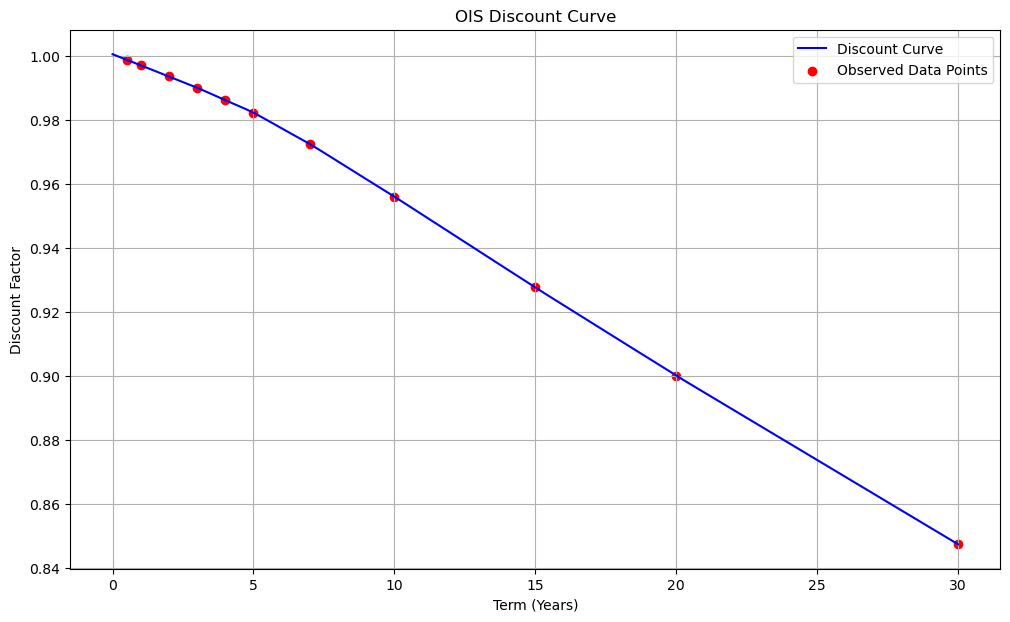

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount Curve', color='blue')
plt.scatter(ois_data['Tenor'], ois_data['Discount Factor'], color='red', label='Observed Data Points')
plt.title('OIS Discount Curve')
plt.xlabel('Term (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True)
plt.show()

## Question 2

In [14]:
# Get IRS data
data = pd.ExcelFile('IR Data.xlsx')
irs_data = pd.read_excel(data, sheet_name=0) 

In [15]:
# Clean up
irs_data = irs_data.drop(['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], axis=1)

In [16]:
# Parse Tenors
def tenor_to_years(tenor):
    tenor_str = str(tenor)
    if 'm' in tenor_str:
        return int(tenor.strip('m')) / 12
    elif 'y' in tenor_str:
        return int(tenor.strip('y'))
    else:
        raise ValueError("Unrecognized tenor format")
        
irs_data['Tenor'] = irs_data['Tenor'].apply(tenor_to_years)

irs_data['Tenor']

0      0.5
1      1.0
2      2.0
3      3.0
4      4.0
5      5.0
6      7.0
7     10.0
8     15.0
9     20.0
10    30.0
Name: Tenor, dtype: float64

In [17]:
t1 = pd.DataFrame(np.arange(0.5, 30.5, 0.5), columns = ['Tenor'])

irs_data1 = pd.merge(t1,irs_data, on='Tenor', how='left')
ois_data2 = pd.merge(t1,ois_data, on='Tenor', how='left')
oisirs_data = pd.merge(ois_data2, irs_data1, on = 'Tenor', how = 'left')
# Introduce new columns
oisirs_data['Forward Rate_y'] = np.nan
oisirs_data['Discount Factor_y'] = np.nan

oisirs_data

,Tenor,Product_x,Rate_x,Forward Rate,Discount Factor,Product_y,Rate_y,Forward Rate_y,Discount Factor_y
0,0.5,OIS,0.00250,0.002498,0.998752,LIBOR,0.0250,NaN,NaN
1,1.0,OIS,0.00300,0.002995,0.997009,IRS,0.0280,NaN,NaN
2,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,OIS,0.00325,0.003495,0.993531,IRS,0.0300,NaN,NaN
4,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,OIS,0.00335,0.003545,0.990015,IRS,0.0315,NaN,NaN
6,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,OIS,0.00350,0.003946,0.986117,IRS,0.0325,NaN,NaN
8,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,OIS,0.00360,0.003996,0.982184,IRS,0.0330,NaN,NaN


In [18]:
# Calculate the first forward rate using the 6-month OIS rate
oisirs_data.at[0, 'Forward Rate_y'] = oisirs_data.at[0,'Rate_y']

# Calculate the first discount factor using the computed forward rate
oisirs_data.at[0, 'Discount Factor_y'] = 1 / (1 + oisirs_data.at[0, 'Rate_y'] * (oisirs_data.at[0, 'Tenor']))

# Calculate the second forward rate using the 1-year OIS rate and the first forward rate
oisirs_data.at[1, 'Forward Rate_y'] =  (oisirs_data.at[1,'Rate_y'] * (oisirs_data.at[0,'Discount Factor'] + oisirs_data.at[1,'Discount Factor']) - (oisirs_data.at[0,'Forward Rate_y'] * oisirs_data.at[0,'Discount Factor'])) / oisirs_data.at[1,'Discount Factor']

# Calculate the second discount factor using the first and second forward rates
oisirs_data.at[1, 'Discount Factor_y'] = (1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[0, 'Forward Rate_y'])  * (1 / (1 + oisirs_data.at[0, 'Tenor'] * oisirs_data.at[1, 'Forward Rate_y'])))
oisirs_data['Discount Factor'].interpolate(method = 'linear', inplace = True)
oisirs_data1 = oisirs_data

In [19]:
def libor_df(x):
    df_diff = oisirs_data['Discount Factor_y'][i-2] - x
    df_p = [oisirs_data['Discount Factor_y'][i-2]]
    libor_payment = []
    for n in range(0, h-i+2):
        df_c = x + ((h - i - n + 1)/(h - i + 2)) * df_diff
        libor = 0.5 * (2 * (df_p[-1] - df_c) / df_c) * oisirs_data['Discount Factor'][i-1+n]
        df_p.append(df_c)
        libor_payment.append(libor)
    flt_x = sum(libor_payment)
    return flt_x + flt - fix

In [20]:
i = 3
while i <= 60:
    h = i
    # Ensure h is within the DataFrame index range
    while np.isnan(oisirs_data['Rate_y'][h]):
        h += 2
    fix = 0.5 * oisirs_data['Rate_y'][h] * oisirs_data['Discount Factor'][0 : h + 1].sum()
    flt = 0
    k = 0
    while k <= i-2:
        flt_i = 0.5 * oisirs_data['Discount Factor'][k] * oisirs_data['Forward Rate_y'][k]
        flt += flt_i
        k += 1
        
    f = lambda x: libor_df(x)
    df_libor = brentq(f, 0, 1)
    for n in range(0, h - i + 2):
#         if i-1+n < len(oisirs_data):  # Ensure the index is within the DataFrame
            oisirs_data['Discount Factor_y'][i-1+n] = df_libor + ((h- i - n + 1)/(h -i + 2))*(oisirs_data['Discount Factor_y'][i-2] - df_libor)
            oisirs_data['Forward Rate_y'][i-1+n] = (oisirs_data['Discount Factor_y'][i - 2 + n] - oisirs_data['Discount Factor_y'][i - 1 + n]) / (0.5 * oisirs_data['Discount Factor_y'][i - 1 + n])
    i = h + 2

In [21]:
oisirs_data1 = oisirs_data
oisirs_data1 = oisirs_data.dropna()
oisirs_data1

,Tenor,Product_x,Rate_x,Forward Rate,Discount Factor,Product_y,Rate_y,Forward Rate_y,Discount Factor_y
0,0.5,OIS,0.00250,0.002498,0.998752,LIBOR,0.0250,0.025000,0.987654
1,1.0,OIS,0.00300,0.002995,0.997009,IRS,0.0280,0.031005,0.972577
3,2.0,OIS,0.00325,0.003495,0.993531,IRS,0.0300,0.032263,0.942179
5,3.0,OIS,0.00335,0.003545,0.990015,IRS,0.0315,0.034814,0.910482
7,4.0,OIS,0.00350,0.003946,0.986117,IRS,0.0325,0.035838,0.878981
9,5.0,OIS,0.00360,0.003996,0.982184,IRS,0.0330,0.035326,0.848989
13,7.0,OIS,0.00400,0.005015,0.972406,IRS,0.0350,0.041298,0.784216
19,10.0,OIS,0.00450,0.005712,0.955977,IRS,0.0370,0.044033,0.692710
29,15.0,OIS,0.00500,0.006097,0.927611,IRS,0.0400,0.051401,0.551081
39,20.0,OIS,0.00525,0.006100,0.900076,IRS,0.0450,0.069994,0.408218


In [28]:
oisirs_data1.rename(columns={
    'Rate_x': 'OIS Rate',
    'Forward Rate': 'OIS Forward Rate',
    'Discount Factor':'OIS Discount Factor',
    'Rate_y':'IRS Rate',
    'Forward Rate_y': 'IRS Forward Rate',
    'Discount Factor_y':'IRS Discount Factor',
    # ... continue for other columns
}, inplace=True)

oisirs_data1.to_excel("transformed_data.xlsx", index=False)
oisirs_data1

,Tenor,Product_x,OIS Rate,OIS Forward Rate,OIS Discount Factor,Product_y,IRS Rate,IRS Forward Rate,IRS Discount Factor
0,0.5,OIS,0.00250,0.002498,0.998752,LIBOR,0.0250,0.025000,0.987654
1,1.0,OIS,0.00300,0.002995,0.997009,IRS,0.0280,0.031005,0.972577
3,2.0,OIS,0.00325,0.003495,0.993531,IRS,0.0300,0.032263,0.942179
5,3.0,OIS,0.00335,0.003545,0.990015,IRS,0.0315,0.034814,0.910482
7,4.0,OIS,0.00350,0.003946,0.986117,IRS,0.0325,0.035838,0.878981
9,5.0,OIS,0.00360,0.003996,0.982184,IRS,0.0330,0.035326,0.848989
13,7.0,OIS,0.00400,0.005015,0.972406,IRS,0.0350,0.041298,0.784216
19,10.0,OIS,0.00450,0.005712,0.955977,IRS,0.0370,0.044033,0.692710
29,15.0,OIS,0.00500,0.006097,0.927611,IRS,0.0400,0.051401,0.551081
39,20.0,OIS,0.00525,0.006100,0.900076,IRS,0.0450,0.069994,0.408218


In [23]:
terms = np.linspace(0, 30, 1200)
from scipy.interpolate import CubicSpline

# Create a cubic spline function based on the tenor and discount factors
cs = CubicSpline(oisirs_data1['Tenor'].values, oisirs_data1['IRS Discount Factor'].values)

# Evaluate the spline function over the range of terms to get interpolated discount factors
interpolated_discount_factors = cs(terms)

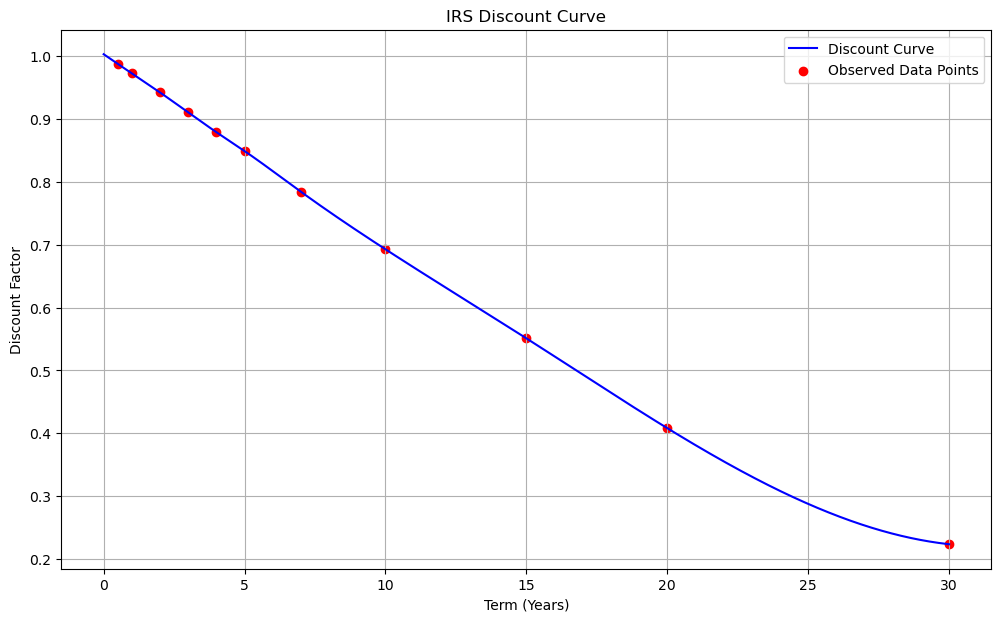

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(terms, interpolated_discount_factors, label='Discount Curve', color='blue')
plt.scatter(oisirs_data1['Tenor'], oisirs_data1['IRS Discount Factor'], color='red', label='Observed Data Points')
plt.title('IRS Discount Curve')
plt.xlabel('Term (Years)')
plt.ylabel('Discount Factor')
plt.legend()
plt.grid(True)
plt.show()

## Question 3

In [25]:
expiry = ['1Y', '5Y', '10Y']
tenors = ['1Y', "2Y", '3Y', '5Y', '10Y']

In [26]:
par_swap_rate = []
for expiries in expiry:
    for tenor in tenors:
        # Remove 'Y'
        i = int(expiries.strip()[:-1]) 
        j = int(tenor.strip()[:-1])
        
        fix = 0.5*sum(oisirs_data['Discount Factor'][2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            flt = oisirs_data['Discount Factor'][x] * (oisirs_data['Discount Factor_y'][x-1] - oisirs_data['Discount Factor_y'][x])/oisirs_data['Discount Factor_y'][x]
            terms.append(flt)
        flt_payment = sum(terms)
        
        par_swap_rate.append(flt_payment/fix)

In [29]:
par_swap_rate_table = np.array(par_swap_rate).reshape(3, 5)
par_swap_rate = pd.DataFrame(par_swap_rate_table, columns = tenors, index = expiry)
par_swap_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458
